In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
import pandas as pd

In [2]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


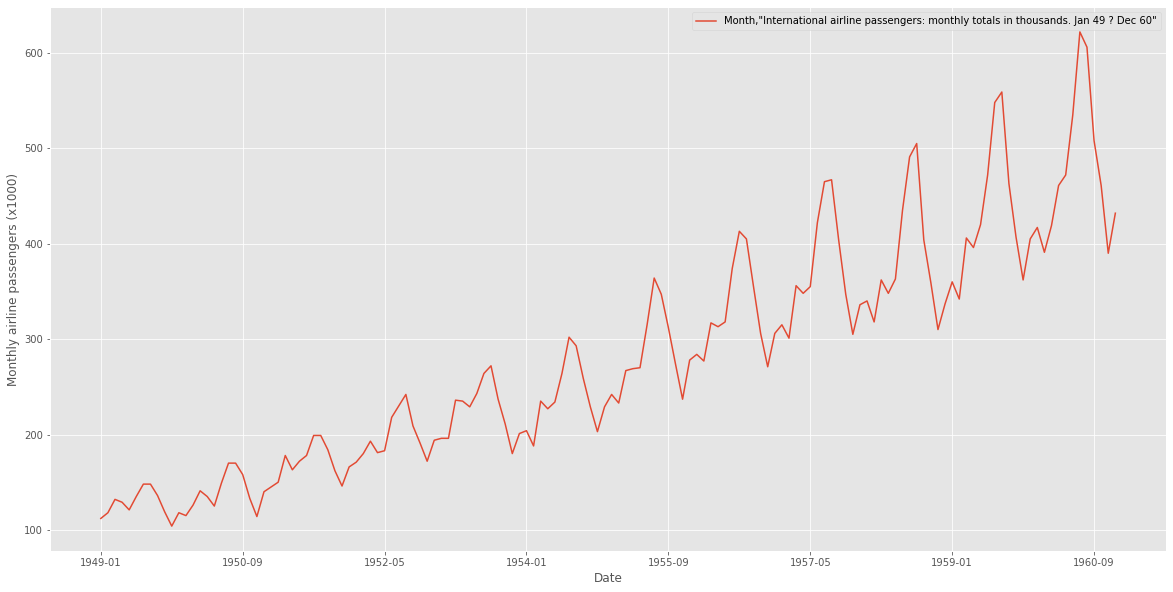

In [20]:
# load the dataset
dataframe = read_csv('/content/international-airline-passengers.csv')

# Plot the data
dataframe.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

In [21]:
train_size = dataframe['1949-01-01':'1959-12-01']
test_size = dataframe['1960-01-01':'1960-12-01']

In [22]:
dataset = dataframe.values
dataset = dataframe.astype('float32') #COnvert values to float

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer test_size and train_size

train_size  = scaler.fit_transform(train_size)
test_size  = scaler.fit_transform(test_size)

dataset = scaler.fit_transform(dataset)


In [26]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

TypeError: ignored

In [25]:
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [27]:
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 4s - loss: 0.0653 - val_loss: 0.3247 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0472 - val_loss: 0.2523 - 48ms/epoch - 16ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0331 - val_loss: 0.1886 - 47ms/epoch - 16ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0225 - val_loss: 0.1336 - 43ms/epoch - 14ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0141 - val_loss: 0.0889 - 47ms/epoch - 16ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0094 - val_loss: 0.0556 - 62ms/epoch - 21ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0079 - val_loss: 0.0353 - 49ms/epoch - 16ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0089 - val_loss: 0.0256 - 47ms/epoch - 16ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0101 - val_loss: 0.0227 - 45ms/epoch - 15ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0100 - val_loss: 0.0233 - 51ms/epoch - 17ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0091 - val_loss: 0.0263 - 53ms/epoch - 18ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0078 - val_loss: 0.0306 - 45ms/epoch - 15ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0069 - va

In [29]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [30]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 21.40 RMSE
Test Score: 54.29 RMSE


In [17]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict


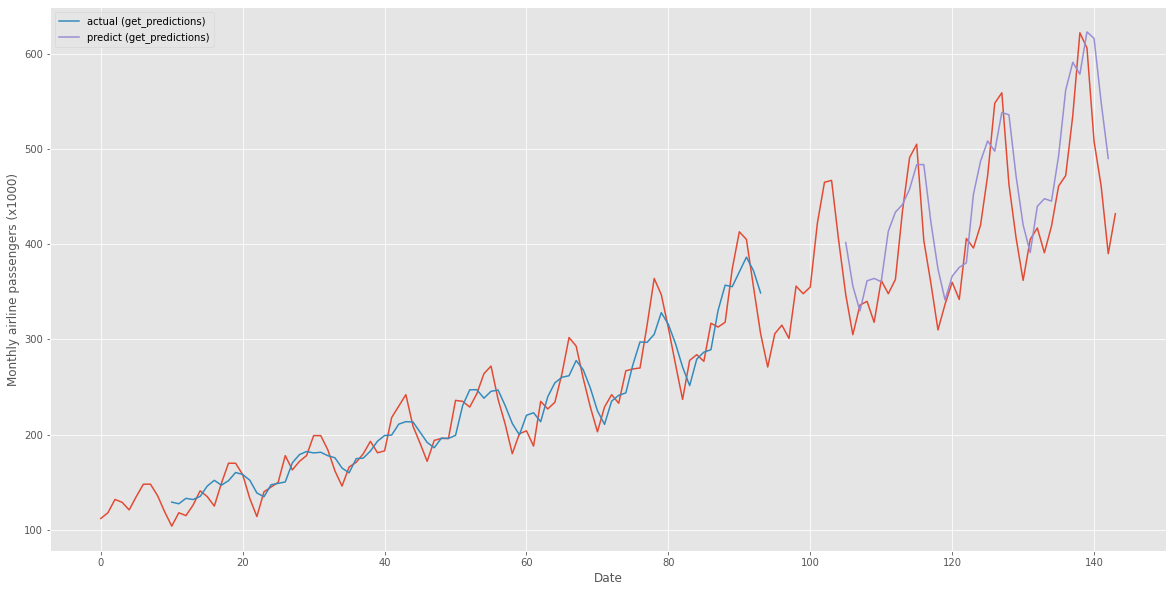

In [37]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,label='actual (get_predictions)')
plt.plot(testPredictPlot,label='predict (get_predictions)')
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()